In [1]:
%load_ext autotime

time: 336 µs (started: 2022-08-17 05:51:01 +00:00)


In [2]:
# Setting the environment variables
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

time: 1.86 ms (started: 2022-08-17 05:51:01 +00:00)


In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Python Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

time: 9.41 s (started: 2022-08-17 05:51:01 +00:00)


# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [4]:
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
spark

time: 48 s (started: 2022-08-17 05:51:11 +00:00)


In [5]:
# Loading the clean data
df = spark.read.parquet("Parquets/cleaned_df.parquet")

time: 5.19 s (started: 2022-08-17 05:51:59 +00:00)


<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [6]:
# Additional steps for Logistic regression - Feature selection, Correlation, etc.


time: 417 µs (started: 2022-08-17 05:52:04 +00:00)


#### Feature Transformation

In [7]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns
df.printSchema()

root
 |-- price: float (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- category_code_primary: string (nullable = true)
 |-- category_code_secondary: string (nullable = true)
 |-- category_code_tertiary: string (nullable = true)
 |-- total_activities_count: integer (nullable = true)
 |-- user_product_count: integer (nullable = true)
 |-- category_secondary_count: integer (nullable = true)
 |-- average_price: float (nullable = true)
 |-- session_count: integer (nullable = true)
 |-- hours: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- is_purchased: integer (nullable = true)

time: 25.5 ms (started: 2022-08-17 05:52:04 +00:00)


In [8]:
df.groupBy("day_of_week").count().show()

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|127641|
|          6|137820|
|          3|134835|
|          5|127216|
|          4|130523|
|          7|126569|
|          2|113839|
+-----------+------+

time: 3.9 s (started: 2022-08-17 05:52:04 +00:00)


In [9]:
# Categorising the attributes into its type - Continuous and Categorical
string_cols = ["category_code_primary", "category_code_secondary", "brand"]

print(f"Categorical String Columns: {string_cols}")
string_indexers = [StringIndexer(inputCol=column, 
                                 outputCol=f"{column}_stridx") for column in string_cols]

Categorical String Columns: ['category_code_primary', 'category_code_secondary', 'brand']
time: 879 ms (started: 2022-08-17 05:52:08 +00:00)


In [10]:
# Feature transformation for categorical features
categorical_cols =  [f"{col}_stridx" for col in string_cols] + \
                    ["hours"]

print(f"Categorical Numerical Columns: {categorical_cols}")                                       
ohe_indexers = [OneHotEncoder(inputCol=column, 
                              outputCol=f"{column}_ohe") for column in categorical_cols]

Categorical Numerical Columns: ['category_code_primary_stridx', 'category_code_secondary_stridx', 'brand_stridx', 'hours']
time: 19.5 ms (started: 2022-08-17 05:52:09 +00:00)


In [11]:
# Vector assembler to combine all the features
vector_columns = [f"{col}_ohe" for col in categorical_cols] + ["price", "day_of_week", "total_activities_count", 
                                                               "user_product_count", "average_price",
                                                               "category_secondary_count", "session_count"]

print(f"Vector Assembler Features: {vector_columns}")

vector_assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

Vector Assembler Features: ['category_code_primary_stridx_ohe', 'category_code_secondary_stridx_ohe', 'brand_stridx_ohe', 'hours_ohe', 'price', 'day_of_week', 'total_activities_count', 'user_product_count', 'average_price', 'category_secondary_count', 'session_count']
time: 10.8 ms (started: 2022-08-17 05:52:09 +00:00)


In [12]:
# Pipeline for the tasks
indexers = string_indexers + ohe_indexers + [vector_assembler]
pipeline = Pipeline(stages=indexers)

time: 996 µs (started: 2022-08-17 05:52:09 +00:00)


In [13]:
# Transforming the dataframe df
df_transformed = pipeline.fit(df).transform(df)

time: 5.64 s (started: 2022-08-17 05:52:09 +00:00)


In [14]:
# Schema of the transformed df
df_transformed.printSchema()

root
 |-- price: float (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- category_code_primary: string (nullable = true)
 |-- category_code_secondary: string (nullable = true)
 |-- category_code_tertiary: string (nullable = true)
 |-- total_activities_count: integer (nullable = true)
 |-- user_product_count: integer (nullable = true)
 |-- category_secondary_count: integer (nullable = true)
 |-- average_price: float (nullable = true)
 |-- session_count: integer (nullable = true)
 |-- hours: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- category_code_primary_stridx: double (nullable = false)
 |-- category_code_secondary_stridx: double (nullable = false)
 |-- brand_stridx: double (nullable = false)
 |-- category_code_primary_stridx_ohe: vector (nullable = true)
 |-- category_code_secondary_stridx_ohe: vector (nullable = true)
 |-- brand_stridx_ohe: vector (nullable = true)
 |-- hours_ohe: vector (nullable 

In [15]:
# Checking the elements of the transformed df - Top 20 rows
df_transformed.show(20, truncate=False)

+-------+-----------+---------------------+-----------------------+----------------------+----------------------+------------------+------------------------+-------------+-------------+-----+-------+------------+----------------------------+------------------------------+------------+--------------------------------+----------------------------------+----------------+-------------+-------------------------------------------------------------------------------------------------------------------+
|price  |day_of_week|category_code_primary|category_code_secondary|category_code_tertiary|total_activities_count|user_product_count|category_secondary_count|average_price|session_count|hours|brand  |is_purchased|category_code_primary_stridx|category_code_secondary_stridx|brand_stridx|category_code_primary_stridx_ohe|category_code_secondary_stridx_ohe|brand_stridx_ohe|hours_ohe    |features                                                                                                           

In [16]:
# Storing the transformed df in S3 bucket to prevent repetition of steps again
if not "transformed_df.parquet" in os.listdir("Parquets"):
    print("Saving Transformed Dataframe to 'Parquets/transformed_df.parquet'")
    df_transformed.coalesce(1).write.option("header", "true").parquet("Parquets/transformed_df.parquet")
else:
    print("Transformed Dataframe already available at 'Parquets/transformed_df.parquet'")

Saving Transformed Dataframe to 'Parquets/transformed_df.parquet'
time: 15.3 s (started: 2022-08-17 05:52:15 +00:00)


#### Train-test split

In [17]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
df_train, df_test = df_transformed.randomSplit([0.7, 0.3], seed=42)


time: 24.7 ms (started: 2022-08-17 05:52:30 +00:00)


In [18]:
# Number of rows in train and test data
print(f"Number of Train rows: {df_train.count()}")
print(f"Number of Test rows: {df_test.count()}")

Number of Train rows: 628038
Number of Test rows: 270405
time: 14.5 s (started: 2022-08-17 05:52:30 +00:00)


#### Model Fitting

In [19]:
label_column = "is_purchased"

time: 549 µs (started: 2022-08-17 05:52:45 +00:00)


In [20]:
# Building the model
lr = LogisticRegression(featuresCol="features", labelCol=label_column)

time: 124 ms (started: 2022-08-17 05:52:45 +00:00)


In [21]:
# Fitting the model on transformed df
lr_model = lr.fit(df_train)

time: 33.7 s (started: 2022-08-17 05:52:45 +00:00)


#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [22]:
result_test = lr_model.evaluate(df_test)

time: 371 ms (started: 2022-08-17 05:53:19 +00:00)


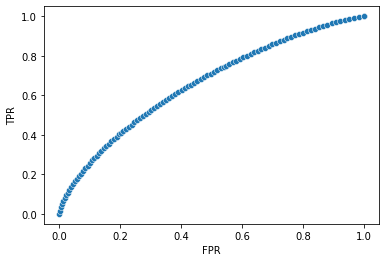

time: 14.6 s (started: 2022-08-17 05:53:19 +00:00)


In [23]:
sns.scatterplot(data=lr_model.summary.roc.toPandas(), x="FPR", y="TPR")
plt.show()

In [24]:
print(f"Area under ROC: {lr_model.summary.areaUnderROC}")

Area under ROC: 0.6586096281782211
time: 76.2 ms (started: 2022-08-17 05:53:33 +00:00)


In [25]:
results_df = result_test.predictions.coalesce(1)
results_pd = results_df.toPandas()
confusion_matrix_pd = results_pd.groupby([label_column, "prediction"]).size().reset_index(name="count")
confusion_matrix_pd.head()

,is_purchased,prediction,count
0,0,0.0,30082
1,0,1.0,76244
2,1,0.0,21674
3,1,1.0,142405


time: 1min 25s (started: 2022-08-17 05:53:34 +00:00)


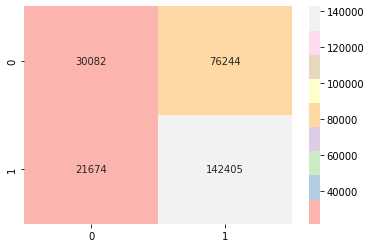

Recall/Sensitivity       : 0.8679050944971629
Precision                : 0.6512949979190392
Specificity              : 0.2829223332016628
Negative Predictive Value: 0.5812272973181853
F1 Score                 : 0.7441577308166635
Negative F1 Score        : 0.38058729014056
time: 246 ms (started: 2022-08-17 05:54:59 +00:00)


In [26]:
TP = confusion_matrix_pd[(confusion_matrix_pd[label_column]==1) & (confusion_matrix_pd.prediction==1)]["count"].values
FP = confusion_matrix_pd[(confusion_matrix_pd[label_column]==0) & (confusion_matrix_pd.prediction==1)]["count"].values
FN = confusion_matrix_pd[(confusion_matrix_pd[label_column]==1) & (confusion_matrix_pd.prediction==0)]["count"].values
TN = confusion_matrix_pd[(confusion_matrix_pd[label_column]==0) & (confusion_matrix_pd.prediction==0)]["count"].values

TP = TP[0] if bool(TP) else 0
FP = FP[0] if bool(FP) else 0
TN = TN[0] if bool(TN) else 0
FN = FN[0] if bool(FN) else 0

confussion_matrix = np.array([[TN, FP],
                              [FN, TP]])
sns.heatmap(confussion_matrix, annot=True, cmap="Pastel1", fmt="g")
plt.show()
recall = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
negative_predictive_value = TN / (TN + FN)

f1_score = 2 * (recall * precision) / (recall + precision)
negative_f1_score = 2 * (specificity * negative_predictive_value) / \
                        (specificity + negative_predictive_value)

print(f"{'Recall/Sensitivity': <25}: {recall}")
print(f"{'Precision': <25}: {precision}")
print(f"{'Specificity': <25}: {specificity}")
print(f"{'Negative Predictive Value': <25}: {negative_predictive_value}")
print(f"{'F1 Score': <25}: {f1_score}")
print(f"{'Negative F1 Score': <25}: {negative_f1_score}")

#### Updated model, if any
Repeat the steps 

In [27]:
# Initialising LogisticRegression
log_reg = LogisticRegression(featuresCol="features", 
                             labelCol="is_purchased", 
                             family="auto")

# Creating Parameter Grid search on LR model
reg_params = [0.001, 0.01, 0.1, 0.2]
max_iters = [10, 15, 20]
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

param_grid = ParamGridBuilder().addGrid(log_reg.regParam, reg_params) \
                               .addGrid(log_reg.maxIter, max_iters) \
                               .addGrid(log_reg.threshold, thresholds) \
                               .build()

class_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, 
                                                    metricName="accuracy")

cross_validator = CrossValidator(estimator=log_reg,
                                 estimatorParamMaps=param_grid,
                                 evaluator=class_evaluator,
                                 numFolds=10,
                                 parallelism=4)

# Run cross-validation, and choose the best set of parameters.
cross_validator_model = cross_validator.fit(df_train)

# Make predictions on testing data and calculating ROC metrics and model accuracy. 
prediction = cross_validator_model.transform(df_test)

time: 37min 3s (started: 2022-08-17 05:54:59 +00:00)


In [28]:
best_model_params = cross_validator_model.getEstimatorParamMaps()[np.argmax(cross_validator_model.avgMetrics)]
param_keys = list(best_model_params.keys())
for param in param_keys:
    print(f"{param.name} = {best_model_params[param]}")

regParam = 0.001
maxIter = 15
threshold = 0.5
time: 952 µs (started: 2022-08-17 06:32:02 +00:00)


In [29]:
best_model = cross_validator_model.bestModel
best_model_result = best_model.evaluate(df_test)

time: 150 ms (started: 2022-08-17 06:32:02 +00:00)


In [30]:
print(f"{'Accuracy': <20}: {best_model_result.accuracy}")
print(f"{'Area Under ROC': <20}: {best_model_result.areaUnderROC}")
print(f"{'Precision By Label': <20}: {best_model_result.precisionByLabel}")
print(f"{'Recall By Label': <20}: {best_model_result.recallByLabel}")
print(f"{'Weighted TPR': <20}: {best_model_result.weightedTruePositiveRate}")
print(f"{'Weighted FPR': <20}: {best_model_result.weightedFalsePositiveRate}")

Accuracy            : 0.637266322738115
Area Under ROC      : 0.6577404346556953
Precision By Label  : [0.5812705863789669, 0.6501884353493792]
Recall By Label     : [0.2771758553881459, 0.8706111080637985]
Weighted TPR        : 0.637266322738115
Weighted FPR        : 0.4894793592861706
time: 27.1 s (started: 2022-08-17 06:32:03 +00:00)


In [31]:
lr_model_path = "Models/LogisticRegression"
best_model.save(lr_model_path)

time: 327 ms (started: 2022-08-17 06:32:30 +00:00)
